# Split the River Network

This notebook demonstrates a workflow for splitting the NHD river network into equal length segments.
NHD provides a dataset of all rivers in california split by segment and given a unique id (COMID).
For valley characterization we aren't going to characterize the valley of the full river network segments, instead we split into smaller lengths of equal size.


We want our lengths to be split from each river network segment independently. Meaning, we don't continue a length across river network segments.

Note, after reprojecting to Albers and computing the length of the river network segments they are slightly different from the length attribute provided with the NHD, but seem close enough to not worry.


Questions:
- Should we do equal length sections, or just work at the segment level? (in which case we interpolate or normalize the lengths some other way before doing the comparisons that are sensitive to length)
- what to do with segments < length?
- what to do with the remainder? Could do leave as remainder (so small final length), could divide equally between all the lengths, could divide equally between the first and last length
- the edges of each segment are where tributaries meet and probably have different topographies, should they be filtered out via a buffer?
- what is the beginning and end of a segment? did they go out -> in or random or in -> out?
- from the eda, it seems a mean of 1.9km and a 25% of 490m, what length segments should we use?

In [1]:
import glob

import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pygeohydro import WBD
from pynhd import NHD
from shapely import unary_union
from shapely.geometry import box, LineString, MultiPoint
from shapely.ops import split
from shapely.ops import snap

In [2]:
def random_cmap(length=10):
    vals = np.linspace(0,1,length)
    np.random.shuffle(vals)
    cmap = plt.cm.colors.ListedColormap(plt.cm.jet(vals))
    return cmap

In [11]:
aoi = box(-122.4484, 37.0866, -122.24, 37.15)

In [12]:
fields = [
    'COMID',
    'LENGTHKM',
]

nhd = NHD('flowline_mr', outfields = fields)
flowlines = nhd.bygeom(aoi, geo_crs=4326)
flowlines = flowlines.to_crs(3310)
flowlines['length'] = flowlines['geometry'].apply(lambda x: x.length)
flowlines

/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


,geometry,COMID,LENGTHKM,length
0,"LINESTRING (-199854.594 -99875.415, -199827.42...",17682688,2.639,2628.386352
1,"LINESTRING (-199866.875 -99353.244, -199877.97...",17682372,0.532,527.909399
2,"LINESTRING (-199753.786 -98689.097, -199755.45...",17682770,0.056,55.468423
3,"LINESTRING (-199755.458 -98744.540, -199748.59...",17682682,0.665,660.824768
4,"LINESTRING (-199371.846 -97594.926, -199404.93...",17682680,1.470,1466.232860
5,"LINESTRING (-196811.698 -94215.892, -196824.37...",17682676,4.522,4512.084343
6,"LINESTRING (-201152.817 -97202.911, -201147.93...",17682686,4.138,4128.775432
7,"LINESTRING (-201177.593 -97077.549, -201172.70...",17682334,0.129,128.440470
8,"LINESTRING (-201150.407 -95690.817, -201223.84...",17682332,1.483,1473.643572
9,"LINESTRING (-200362.486 -95237.075, -200441.11...",17682296,0.946,949.199387


<Axes: >

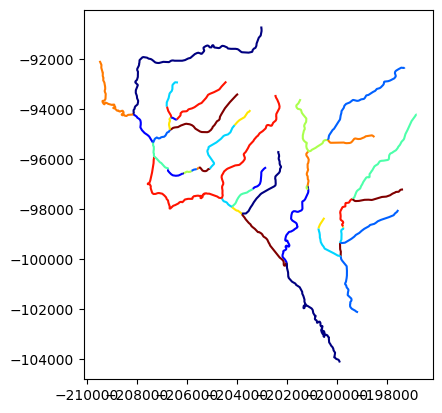

In [13]:
flowlines.plot(cmap=random_cmap())

In [14]:
def segment(line, length=500, method="remainder"):
    # https://gis.stackexchange.com/questions/386482/splitting-line-geodataframe-basing-on-given-lengths/386527#386527
    # https://github.com/shapely/shapely/issues/1058#issuecomment-755016543
    
    if method not in ['remainder', 'equal']:
        raise ValueError(f"method must be 'remainder' or 'equal' when {method} was provided")
    
    if method == "remainder":
        distances = np.arange(0, line.length, length)
    elif method == "equal":
        nparts = line.length // length
        if nparts == 0:
            distances = np.arange(0, line.length, line.length)
        else:        
            distances = np.arange(0, line.length, line.length/nparts)
        
    points = [line.interpolate(distance) for distance in distances] + [line.boundary.geoms[1]]
    points = unary_union(points)
    snapped = snap(line, points, tolerance=0.01) 
    return list(split(snapped, points).geoms)

In [15]:
segments = flowlines.copy()
segments['split'] = segments['geometry'].apply(segment, length=1000, method='remainder')
segments = segments.explode('split')
segments['geometry'] = segments['split']
segments = segments[['geometry', 'COMID', 'LENGTHKM', 'length']]
segments['new_length'] = segments['geometry'].apply(lambda x: x.length)
segments

/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


,geometry,COMID,LENGTHKM,length,new_length
0,"LINESTRING (-199854.594 -99875.415, -199827.42...",17682688,2.639,2628.386352,1000.000000
0,"LINESTRING (-199621.674 -100796.449, -199641.5...",17682688,2.639,2628.386352,1000.000000
0,"LINESTRING (-199436.146 -101676.162, -199466.9...",17682688,2.639,2628.386352,628.386352
1,"LINESTRING (-199866.875 -99353.244, -199877.97...",17682372,0.532,527.909399,527.909399
2,"LINESTRING (-199753.786 -98689.097, -199755.45...",17682770,0.056,55.468423,55.468423
...,...,...,...,...,...
47,"LINESTRING (-201641.638 -101011.454, -201634.4...",17682732,5.885,5867.579941,1000.000000
47,"LINESTRING (-201306.151 -101849.706, -201328.1...",17682732,5.885,5867.579941,1000.000000
47,"LINESTRING (-200880.955 -102376.665, -200881.9...",17682732,5.885,5867.579941,1000.000000
47,"LINESTRING (-200541.674 -102947.295, -200540.5...",17682732,5.885,5867.579941,1000.000000


<Axes: >

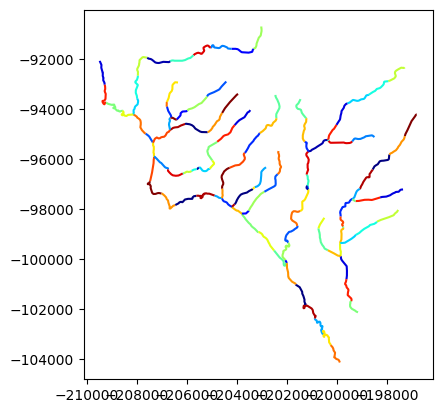

In [19]:
segments['geometry'].plot(cmap=random_cmap(25))

In [20]:
segments.to_file('../data/segments_sample.shp')  